# LSTM, word embedding, enrich domain 2

In [1]:
import joblib
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import json 
from sklearn.model_selection import train_test_split


model_name = 'lstm_bid_SMOTE_models'

In [3]:
# Import data
import zipfile

zip_file = zipfile.ZipFile('llm-detect-ai-generated-text.zip')
train_data = zip_file.open('train_essays.csv')
train_prompts = zip_file.open('train_prompts.csv')
# test data is just exmaple data, not the actual test data
test_data = zip_file.open('test_essays.csv')
sample_sub = zip_file.open('sample_submission.csv')

data_train = pd.read_csv(train_data)
data_test = pd.read_csv(test_data)
train_prompts =  pd.read_csv(train_prompts)
sample_sub =  pd.read_csv(sample_sub)

In [14]:
# external data
daigt_file = zipfile.ZipFile('daigt.zip')
argugpt_file = zipfile.ZipFile('argugpt.zip')
daigt_data = daigt_file.open('train_drcat_04.csv')
argugpt_data = argugpt_file.open('argugpt.csv')
daigt_data = pd.read_csv(daigt_data)[['essay_id', 'text', 'prompt', 'label']]
# rename columns to match the other data
daigt_data.columns = ['id', 'text', 'prompt_id', 'generated']
argugpt_data = pd.read_csv(argugpt_data)[['id', 'text', 'model']]
argugpt_data.columns = ['id', 'text', 'prompt_id']
# add column 'generated' full of 1 to match the other data
argugpt_data['generated'] = 1

In [15]:
daigt_data.head()

,id,text,prompt_id,generated
0,E897534557AF,"In recent years, technology has had a profoun...",\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,NaN,0
2,af37ecf5,The electoral college is a symbol of mockery a...,NaN,0
3,5EC2696BAD78,This is why I think the principle should allow...,NaN,0
4,llama_70b_v1843,I strongly believe that meditation and mindful...,Some schools have implemented meditation and m...,1


In [16]:
argugpt_data.head()

,id,text,prompt_id,generated
0,weccl_30,There are many people who think that universit...,text-babbage-001,1
1,weccl_51,There are a number of reasons why people might...,text-babbage-001,1
2,weccl_48,There are many reasons why university educatio...,text-babbage-001,1
3,weccl_50,There are many people who think that universit...,text-babbage-001,1
4,weccl_55,There is a general consensus that university e...,text-babbage-001,1


In [7]:
print(data_train.shape)
data_train.head()

(1378, 4)


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [17]:
# concate all data by matching columns
data_train = pd.concat([data_train, daigt_data, argugpt_data], axis=0)
print(data_train.shape)
data_train.head()

(49622, 4)


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


# EDA

In [28]:
# show different values in prompt_id column
data_train.prompt_id.value_counts()

# where prompt_id is gpt-3.5-turbo, text-davinci-003, text-curie-001,text-davinci-002 or None,
# replace with none
data_train.prompt_id = data_train.prompt_id.replace(['gpt2-xl', 'text-babbage-001', 'gpt-3.5-turbo', 'text-davinci-003', 'text-davinci-002','text-davinci-001', 'text-curie-001', None], 'none')
data_train.prompt_id.value_counts()

# print all the different values in prompt_id column, write to txt file
with open('prompt_id.txt', 'w') as f:
    for item in data_train.prompt_id.unique():
        f.write("%s\n" % item)

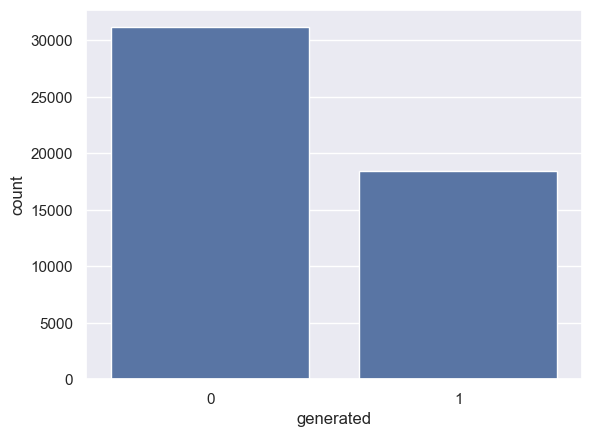

In [20]:
# check and plot the distribution of the prompt_id and generated attributes
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x="generated", data=data_train)
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

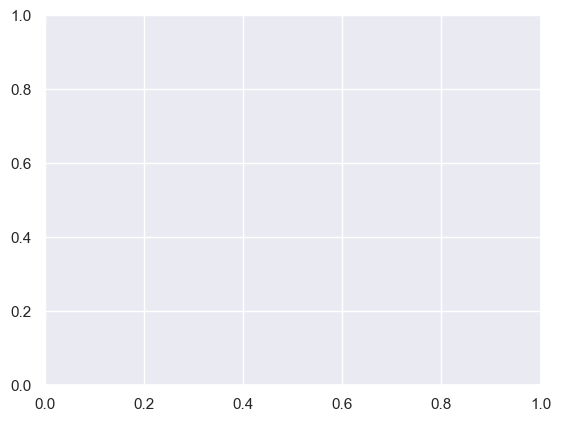

In [18]:

sns.set(style="darkgrid")
sns.countplot(x="prompt_id", data=data_train)
plt.show()
plt.clf()

sns.countplot(x="generated", data=data_train)
plt.show()


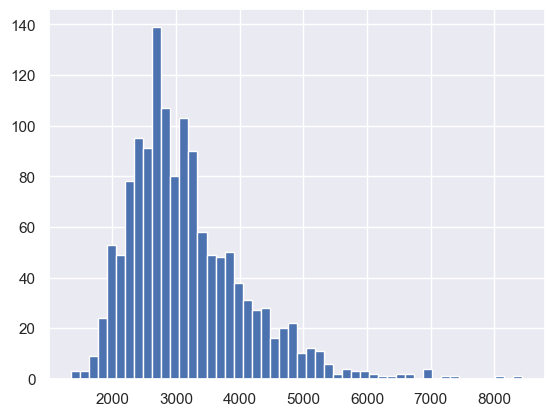

In [13]:
# plot the distribution of the length of the essays in the text attribute
data_train['text'].str.len().hist(bins = 50)
plt.show()

In [25]:
# print this train_prompts[0][3] to see the prompt
# significant paragraphs are separated by \n\n{i} where i is the paragraph number
print(len(train_prompts['source_text'][0]))
print(len(train_prompts['source_text'][1]))
print(train_prompts['source_text'][1])

13081
12213
# What Is the Electoral College? by the Office of the Federal Register

1 The Electoral College is a process, not a place. The founding fathers established it in the Constitution as a compromise between election of the President by a vote in Congress and election of the President by a popular vote of qualified citizens.

2 The Electoral College process consists of the selection of the electors, the meeting of the electors where they vote for President and Vice President, and the counting of the electoral votes by Congress.

3 The Electoral College consists of 538 electors. A majority of 270 electoral votes is required to elect the President. Your state’s entitled allotment of electors equals the number of members in its Congressional delegation: one for each member in the House of Representatives plus two for your Senators. . . .

4 Under the 23rd Amendment of the Constitution, the District of Columbia is allocated 3 electors and treated like a state for purposes of the Ele

In [27]:
# check a few essays to see if they refer to numbers or authors
print(f"prompt number {data_train['prompt_id'][0]}: {train_prompts['prompt_name'][data_train['prompt_id'][0]]}")
print(data_train['text'][0])

prompt number 0: Car-free cities
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting 

In [114]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import tokenize words
word_list = words.words()
print("Hello" in word_list)
print("hello" in word_list)

False
True


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
def preprocess_text(text):
    # remove non-english words, remove stopwords, and punctuation
    text = text.lower()
    text = word_tokenize(text)
    # only keep words that are in the word_list
    text = [word for word in text if word in word_list]
    # only keep words that are alphanum (not punctuation)
    text = [word for word in text if word.isalphanum()]
    # remove stopwords
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

def get_names(text):
    # remove non-english words, and punctuation
    text = text.lower()
    text = word_tokenize(text)
    names = [word for word in text if word not in word_list]
    names = [word for word in names if word.isalpha()]
    return names

In [154]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/ner-english")

2024-01-08 15:17:18,631 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [161]:
# init result
res = []

# make sentence
for i, sentence in enumerate(data_train['text']):
    sentence = Sentence(data_train['text'][0])

    # predict NER tags
    tagger.predict(sentence)

    # iterate over entities and print
    for entity in sentence.get_spans('ner'):
        if entity.tag == 'PER':
            res.append(entity.text)

    if i % 50 == 0 and i>0:
        print(f"Processed texts: {i}")
        print(set(res))
        res = []

Processed texts: 50
{'Robert Duffer', 'Andrew Selsky', 'Henry Ford', 'Elizabeth Rosenthal'}
Processed texts: 100
{'Robert Duffer', 'Andrew Selsky', 'Henry Ford', 'Elizabeth Rosenthal'}
Processed texts: 150
{'Robert Duffer', 'Andrew Selsky', 'Henry Ford', 'Elizabeth Rosenthal'}
Processed texts: 200
{'Robert Duffer', 'Andrew Selsky', 'Henry Ford', 'Elizabeth Rosenthal'}


KeyboardInterrupt: 

Additional papers referenced in esssays:
- "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky
- "Paris bans driving due to smog" by Robert Duffer
- Bradford Plumer

In [115]:
preprocess_text(data_train['text'][0])

'have been around since they famous in the when henry ford and built the first have a major role in our every day since then but now people are starting to question if limiting car usage would be a good thing to me limiting the use of might be a good thing to do in like matter of this article in german suburb life goes on without by how are the linchpin of where middle class from either shanghai or tend to make their say how this is a huge impediment to current to reduce greenhouse gas from tailpipe passenger are responsible for percent of greenhouse gas in and up to percent in some in the united are the main reason for the greenhouse gas because of a lot of people driving them around all the time getting where they need to go article driving due to smog by duffer how after days of pollution enforced a partial driving ban to clear the air of the global city it also how on motorist with license were ordered to leave their at home or be a fine the same order would be applied to the follo

In [148]:
# Detect names in the text
data_train['names'] = data_train['text'].apply(get_names)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [125]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# layers size
layer_size = 128

X = data_train['text'].to_numpy()
# Get the target values
Y = data_train['prompt_id'].to_numpy()

# Split the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# # Prepare text for LSTM 
# tokenizer = Tokenizer(num_words=5000, split=' ')
# tokenizer.fit_on_texts(X_train.values)
# X_train = tokenizer.texts_to_sequences(X_train.values)
# X_train = pad_sequences(X_train, maxlen=layer_size)
# X_test = tokenizer.texts_to_sequences(X_test.values)
# X_test = pad_sequences(X_test, maxlen=layer_size)

# print('before resampling (training sample):')
# print(f'shape of data tensor: {X_train.shape}')
# print(f'shape of label: {Y_train.shape}')
# print('class distribution (train):', Y_train.value_counts())
# print('class distribution (test):', Y_test.value_counts())

# # # resample training data to oversample humans
# sm = SMOTE(random_state=12)
# X_train, Y_train = sm.fit_resample(X_train, Y_train)

# print('after resampling (training data):')
# print(f'shape of data tensor: {X_train.shape}')
# print(f'shape of label: {X_train.shape}')
# print('class distribution:', Y_train.value_counts())

# not a very good idea
Y_train = pd.get_dummies(Y_train).values
Y_test = pd.get_dummies(Y_test).values

In [127]:
import tensorflow_hub as hub
import tensorflow as tf

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 1.5381784 ,  0.02649138,  0.02829605,  0.62391067, -0.1523891 ,
        -0.47843793,  0.45972705,  0.46297017, -0.5834272 ,  0.61755604,
        -0.48421705,  0.70191664, -0.43871292, -0.06909778, -0.5293196 ,
        -0.91618806, -0.29832184, -0.3032987 , -0.0513387 , -0.61244535,
        -0.19069357, -0.18210898,  0.3861796 ,  0.16050443, -0.4111805 ,
         0.9160888 , -1.1038368 ,  0.48426992, -0.28801984, -0.71888405,
        -0.42425096,  0.18429187,  0.7231973 , -0.43851936, -0.6890776 ,
         0.06721003, -0.339721  , -0.16151606,  0.46831608, -0.5436493 ,
        -0.00732495,  0.37836894, -0.5065311 ,  0.5892787 , -0.07718211,
        -0.1459924 , -0.05896002, -0.19905514,  0.00166416,  0.10782661]],
      dtype=float32)>

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Reshape

# init layer
model = Sequential()
model.add(hub_layer)
model.add(Reshape((1, -1))) # Add this line to reshape the 2D tensor to a 3D tensor
model.add(Bidirectional(LSTM(25,return_sequences=True)))
model.add(Bidirectional(LSTM(16,return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
for layer in model.layers:
    print(layer.output_shape)

(None, 50)
(None, 1, 50)
(None, 1, 50)
(None, 32)
(None, 32)
(None, 32)
(None, 2)


In [130]:
batch_size = 64 
epochs = 10
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/10
14/14 [==============================] - 14s 668ms/step - loss: 0.6705 - accuracy: 0.6924 - val_loss: 0.6172 - val_accuracy: 0.9955
Epoch 2/10
14/14 [==============================] - 8s 599ms/step - loss: 0.5362 - accuracy: 0.9977 - val_loss: 0.3745 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 8s 589ms/step - loss: 0.2455 - accuracy: 1.0000 - val_loss: 0.0893 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 8s 588ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 8s 583ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 8s 585ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 8s 588ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch

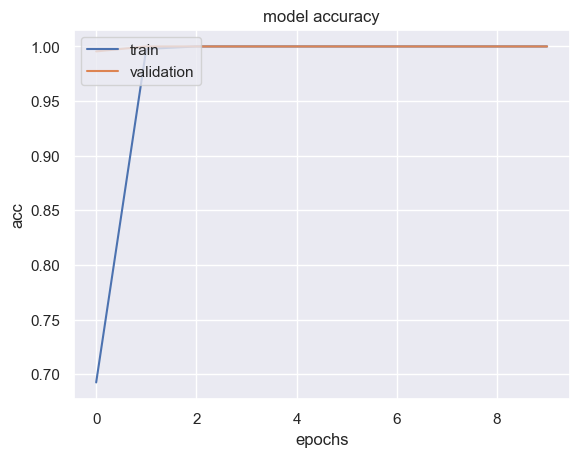

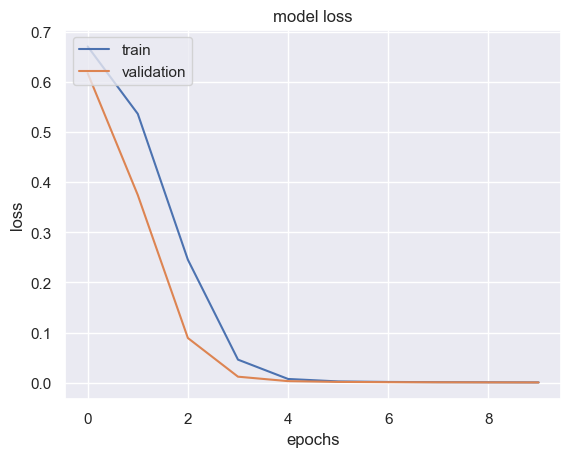

In [131]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [132]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict classes for test set
yhat_classes = [np.argmax(classes) for classes in yhat_probs]

In [141]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Check against true class
Y_true = [np.argmax(classes) for classes in Y_test]

cm = confusion_matrix(yhat_classes, Y_true)
cm

print(f"Confusion metrics: {cm}")
print(classification_report(yhat_classes, Y_true))

Confusion metrics: [[138   0]
 [  0 138]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [144]:
# count values of yhat_classes and Y_true
from collections import Counter

print(Counter(yhat_classes))
print(Counter(Y_true))

Counter({0: 138, 1: 138})
Counter({0: 138, 1: 138})


In [15]:
# Predict test data
test_data = pd.read_csv('Data/test_data.csv')
X_test = test_data['text'].to_numpy()
y_pred = model.predict(X_test, verbose=0)
y_pred = [np.argmax(classes) for classes in y_pred]
y_pred_binary = [1 if e == 8 else 0 for e in y_pred]

# Save the prediction
result = pd.DataFrame(y_pred_binary, columns=['class'])
result['id'] = result.index
result.to_csv(f'Output/{model_name}.csv', columns=['id', 'class'],index=False)

In [ ]:
# # save model
# import joblib

# output_folder = './Models'
# joblib.dump(model, f"{output_folder}/{model_name}.pkl")